In [ ]:
from librosa.core import load as ld_wav
from librosa.feature import delta
import librosa.feature as ft_extraction
import scipy.io.wavfile as wav
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import librosa
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
!pip3 install wisardpkg 
import wisardpkg as wp
from sklearn.metrics import accuracy_score
import time
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation
import pickle
from google.colab import drive
drive.mount('/content/drive')
!pip3 install hyanova
import hyanova

     |████████████████████████████████| 133kB 5.3MB/s 
     |████████████████████████████████| 194kB 6.5MB/s 
  ERROR: Failed building wheel for wisardpkg
  Running setup.py clean for wisardpkg
Failed to build wisardpkg
    Running setup.py install for wisardpkg ... done
Mounted at /content/drive


# Data Extraction

In [ ]:
!ls "/content/drive/My Drive/IRMAS-training"

best_params.txt		       fanova	    PCA		 vio
data_dict.pickle	       KPCA	    pia
data_dict_procVoz.pickle       MFCCresults  PNCC-master
data_dict_procVoz_pncc.pickle  Original     resultados


In [ ]:
# directory where we your .wav files are
directoryName = "/content/drive/My Drive/IRMAS-training/" # put your own directory here
#instruments to evaluate
instruments = ["pia","vio"]

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
def loadTrainTestData(train=True,layer_no=1,method='Original'):
  new_data_dict = {"pia":[],"vio":[]}
  if train:
    #piano - 0 || violino - 1
    y = np.load(directoryName+"{}/Y_DATA/".format(method)+"y_train.npy")
    x = np.load(directoryName+"{}/layer{}/".format(method,layer_no)+"extracted_train.npy")
  else:
    y = np.load(directoryName+"{}/Y_DATA/".format(method)+"y_test.npy")
    x = np.load(directoryName+"{}/layer{}/".format(method,layer_no)+"extracted_test.npy")
  if len(x.shape) == 3:
    for audio,instrument in zip(x,y):
      df = pd.DataFrame(data = audio, columns = ['col_%d'%i for i in range(audio.shape[1])])
      new_data_dict[instruments[instrument]].append(df)
  else:
    df = pd.DataFrame(data = x[np.where(y == 0)], columns = ['col_%d'%i for i in range(x.shape[1])])
    new_data_dict[instruments[0]].append(df)
    df = pd.DataFrame(data = x[np.where(y == 1)], columns = ['col_%d'%i for i in range(x.shape[1])])
    new_data_dict[instruments[1]].append(df)
  return new_data_dict

# Preprocessing

## Aplicar a técnica Append Sum em cada áudio

In [ ]:
# Pseudocódigo
# ============
# Seja D um dicionário, cujas chaves são as classes e os valores correspondem a uma lista, 
# onde cada elemento da lista é um DataFrame Pandas referente a um áudio da classe correspondente
# onde cada linha é um frame do áudio e cada coluna corresponde a um coeficiente MFCC.
# Para cada classe C
  # Para cada áudio A da classe C (A é um DataFrame Pandas)
    # Para cada coluna K de A (K é um Series Pandas)
      # A[K] = AppendSum(K)

# Pseudocódigo AppendSum(K)
# =========================
# K' = [K[0]]
# Para linha = 2 até tamanho(K)
  # K' += [K'[linha-1] + K[linha]]
# Retorna Series(K')

def AppendSum(sequencia):
  """O argumento deve ser um pandas Series."""
  nova_sequencia = [sequencia[0]]
  for linha in (sequencia.index)[1:]:
    nova_sequencia += [nova_sequencia[linha-1] + sequencia[linha]]
  return pd.Series(nova_sequencia)

In [ ]:
def splitData(load=False,layer_no=1,method='Original'):
  if load:
    D_treino = loadTrainTestData(layer_no=layer_no,method=method) 
    D_teste = loadTrainTestData(train=False,layer_no=layer_no,method=method)
    if len(D_treino['pia'][0].shape) == 3:
      for classe in list(D_treino.keys()):
        for A in D_treino[classe]:
          for coluna in A.columns:
            A[coluna] = AppendSum(A[coluna])
      for classe in list(D_teste.keys()):
        for A in D_teste[classe]:
          for coluna in A.columns:
            A[coluna] = AppendSum(A[coluna])
    return D_treino,D_teste   
  else:
    for classe in list(data_dict.keys()):
      for A in data_dict[classe]:
        for coluna in A.columns:
          A[coluna] = AppendSum(A[coluna])
    for classe in list(data_dict.keys()):
      D_treino[classe], D_teste[classe] = train_test_split(data_dict[classe],train_size=int(0.8*len(data_dict[classe])),random_state=0,shuffle=True)
    return D_treino,D_teste

In [ ]:
#D_treino,D_teste = splitData(load=True,layer_no=0)

In [ ]:
#D_treino['pia'][0].shape

# Aplicar Z-Score nos conjuntos de treinamento e teste

In [ ]:
def applyZScore(D_treino,D_teste):
  #D_teste = {'pia':[],'vio':[]}
  #D_treino = {'pia':[],'vio':[]}
  # Concatenar todos áudios do conjunto de treinamento
  concatenado_treino = pd.DataFrame(columns = D_treino['pia'][0].columns)
  for classe in list(D_treino.keys()):
    for A in D_treino[classe]:
      concatenado_treino = concatenado_treino.append(A)
  concatenado_treino.reset_index(drop=True, inplace=True)
  scaler = StandardScaler()

  # Ajustar o Z-Score a partir do conjunto de treinamento
  scaler.fit(concatenado_treino)

  for classe in list(D_treino.keys()):
    new_list = []
    for A in D_treino[classe]:
      #D_treino[classe].append(pd.DataFrame(data =scaler.transform(A),columns = D_treino['pia'][0].columns))
      new_list.append(pd.DataFrame(data =scaler.transform(A),columns = D_treino['pia'][0].columns))
    D_treino[classe] = new_list
  for classe in list(D_teste.keys()):
    new_list = []
    for A in D_teste[classe]:
      #D_teste[classe].append(pd.DataFrame(data =scaler.transform(A),columns = D_teste['pia'][0].columns))
      new_list.append(pd.DataFrame(data =scaler.transform(A),columns = D_treino['pia'][0].columns))
    D_teste[classe] = new_list

# Aplicar a função tanh em todos os valores de ambos os conjuntos

In [ ]:
def applyTANH(D_treino,D_teste):
  # Aplicar tanh no conjunto de treinamento
  for classe in list(D_treino.keys()):
      for i,A in enumerate(D_treino[classe]):
          D_treino[classe][i] = A.apply(np.tanh,axis=1)

  # Aplicar tanh no conjunto de teste
  for classe in list(D_teste.keys()):
      for i,A in enumerate(D_teste[classe]):
          D_teste[classe][i] = A.apply(np.tanh,axis=1)

# Replicar features dos dois frames anteriores e concatenar com o atual para ambos os conjuntos

In [ ]:
def replicateFeatures(D_treino,D_teste):
  nomes_colunas = []
  for column in list(D_treino['pia'][0].columns):
      for i in range(3):
          nomes_colunas.append(column+'('+str(-i)+')')

  # Replicar features no conjunto de treinamento
  for classe in list(D_treino.keys()):
      for i,A in enumerate(D_treino[classe]):
          D_treino[classe][i] = pd.concat([A,A.shift(1),A.shift(2)],axis=1).fillna(0)
          D_treino[classe][i].reset_index(drop=True, inplace=True)
          D_treino[classe][i].columns = nomes_colunas

  # Replicar features no conjunto de teste
  for classe in list(D_teste.keys()):
      for i,A in enumerate(D_teste[classe]):
          D_teste[classe][i] = pd.concat([A,A.shift(1),A.shift(2)],axis=1).fillna(0)
          D_teste[classe][i].reset_index(drop=True, inplace=True)
          D_teste[classe][i].columns = nomes_colunas

# Definir função para aplicar KernelCanvas

**Será usada diversas vezes durante a escolha dos parâmetros**

In [ ]:
def binarizar_sequencia_com_KernelCanvas(sequencia,**kwargs):
    """Dada uma sequencia, ou seja, um DataFrame cujas linhas são as amostras da sequência e as colunas são 
  as features de cada amostra, retorna uma lista de novas entradas mapeadas a partir dos kernels. Essa lista
  tem tamanho bits_por_kernel*numero_kernels e contém apenas zeros e uns."""
    dimensao = len(sequencia.columns)
    kc = wp.KernelCanvas(
      dimensao, 
      kwargs['numberOfKernels'], 
      bitsByKernel     = kwargs['bitsByKernel'], 
      activationDegree = kwargs['activationDegree']
  )
    return kc.transform(sequencia.to_numpy())

In [ ]:
def thermometerEncoder(X, min=0, max=1, size=32):
    X = np.asarray(X)
    if X.ndim == 0:
        f = lambda i: X >= min + i*(max - min)/size
    elif X.ndim == 1:
        f = lambda i, j: X[j] >= min + i*(max - min)/size
    else:
        f = lambda i, j, k: X[k, j] >= min + i*(max - min)/size 
    return  np.fromfunction(
      f,
      (size, *reversed(X.shape)),
      dtype=int
  ).astype(int)


In [ ]:
"""max_ = np.max([D_treino['pia'][0].max(),D_treino['vio'][0].max()])
min_ = np.min([D_treino['pia'][0].min(),D_treino['vio'][0].min()])"""

"max_ = np.max([D_treino['pia'][0].max(),D_treino['vio'][0].max()])\nmin_ = np.min([D_treino['pia'][0].min(),D_treino['vio'][0].min()])"

In [ ]:
#len(D_teste['pia'])

In [ ]:
def flatten(X, column_major=True):
    X = np.asarray(X)
    order = 'F' if column_major else 'C'

    if X.ndim < 2:
        return X
    elif X.ndim == 2:
        return X.ravel(order=order)

    return np.asarray([X[:, :, i].ravel(order=order) for i in range(X.shape[2])])

In [ ]:
"""for A in D_teste['vio']:
  A.to_numpy().flatten()
  break"""

"for A in D_teste['vio']:\n  A.to_numpy().flatten()\n  break"

In [ ]:
def binarizar_com_Termometro(conjunto,**kwargs):
    """ Dado um DataFrame cujas linhas são um vetor de características que representam uma amostra, retorna um dataframe com"""
    database = {'exemplos':[],'classes':[]}
    if len(conjunto['pia']) > 1:
      for classe in conjunto.keys():
        new_list=[]
        for A in conjunto[classe]:
          data = A.to_numpy().flatten()
          new_list.append(data)
        conjunto[classe] = new_list
        database['classes'].extend([classe]*len(conjunto[classe]))
    print("Shape: {}".format(conjunto['pia'][0].shape))
    size = kwargs['termometherSize']
    max_ = kwargs['Max']
    min_ = kwargs['Min']
    if not database['classes']:
      for classe in list(conjunto.keys()):
          database['exemplos'].extend([flatten(thermometerEncoder(A,min=min_,max=max_,size=size)) for A in conjunto[classe]])
          database['classes'].extend([classe]*np.sum([len(A) for A in conjunto[classe]]))
    else:
      for classe in list(conjunto.keys()):
          database['exemplos'].extend([flatten(thermometerEncoder(A,min=min_,max=max_,size=size)) for A in conjunto[classe]])
    database['exemplos'] = np.vstack(database['exemplos'])
    database['classes'] = np.array(database['classes'])

    return database

In [ ]:
# Essa função é mais geral e é capaz de aplicar KernelCanvas em diversas sequências através de uma única chamada
def binarizar_conjunto_com_KernelCanvas(conjunto,**kwargs):
    """ Dada um conjunto, ou seja, um dicionário cujas chaves são as classes e os valores são listas contendo todas 
    as sequências daquela classe, retorna um dicionário contendo as chaves 'classes' e 'exemplos'. O valor da
    chave 'exemplos' é uma lista contendo todos os exemplos do conjunto após a passar pelo KernelCavas, ou seja, 
    cada exemplo é uma lista contendo apenas zeros e uns. Já o valor da chave 'classes' contém uma lista onde 
    cada elemento da lista é a classe do exemplo correspondente à mesma posição. """
    dimensao = len(conjunto[list(conjunto.keys())[0]][0].columns)

    kc = wp.KernelCanvas(
      dimensao, 
      kwargs['numberOfKernels'], 
      bitsByKernel = kwargs['bitsByKernel'], 
      activationDegree = kwargs['activationDegree']
  )

    database = {'exemplos':[],'classes':[]}

    for classe in list(conjunto.keys()):
        for A in conjunto[classe]:
            database['exemplos'] += [kc.transform(A.to_numpy())]
            database['classes'] += [classe]
    database['exemplos'] = np.array(database['exemplos'])
    database['classes'] = np.array(database['classes'])
    return database

## Definir função para realizar validação cruzada estratificada

In [ ]:
def multi_class_stratifiedKFold_split(X,y,n_folds=5,shuffle=True,random_state=5):
    partition_size = 1/n_folds

    np.random.seed(random_state)

    # Separar os exemplos por classe
    examples_by_class = {}
    for i,C in enumerate(y):
        if not C in examples_by_class:
            examples_by_class[C] = []
        examples_by_class[C] += [X[i]]
  
  # Embaralhar os exemplos de cada classe
    if shuffle:
        for C in list(examples_by_class.keys()):
            np.random.shuffle(examples_by_class[C])
      
    # Criar as partições
    folds_examples = [[] for fold in range(n_folds)]
    folds_classes = [[] for fold in range(n_folds)]
    for C in list(examples_by_class.keys()):
        number_of_examples_class_C = len(examples_by_class[C])
        for i,example in enumerate(examples_by_class[C]):
            folds_examples[i%(n_folds)] += [example]
            folds_classes[i%(n_folds)] += [C]

    for fold in range(n_folds):
        X_test, y_test = folds_examples[fold], folds_classes[fold]
        X_train, y_train = [],[]
    for f in range(n_folds):
        if f!=fold:
            X_train += folds_examples[f]
            y_train += folds_classes[f]

    X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)

    yield (X_train, X_test, y_train, y_test)

In [ ]:
def validacao_cruzada(X, y, metric_func, n_folds = 5, shuffle = True, random_state = 5, classificador = 'wisard', **kwargs):
  """ Parâmetros
      ==========
      X: array 2-dimensional
      y: array 1-demensional
      metric_func: uma função de avaliação. Essa função deve receber os parâmetros y_true e y_pred e retornar um float.
      n_folds: número de partições da validação cruzada
      shuffle: booleano. Se True, embaralha o conjunto antes de dividir as partições
      random_state: int. É usado quando se deseja reproduzir o experimento diversas vezes
      classificador: 'wisard' ou 'cluswisard'
      **kwargs: argumentos do classificador

      Resultado
      =========
      4-tupla: (média de metric_func, desvio padrão de metric_func, média do tempo para aprendizado e classificação de uma
                iteração da validação cruzada, desvio padrão do tempo para aprendizado e classificação de uma iteração da 
                validação cruzada)
  """

  if classificador == 'wisard':
    addressSize = kwargs['addressSize']
    clf = wp.Wisard(
        addressSize,
        **kwargs
    )

  skf = multi_class_stratifiedKFold_split(X,y,n_folds=n_folds,shuffle=shuffle,random_state=random_state)

  performances_metric = []

  elapsed_times = []
  
  for X_train,X_test,y_train,y_test in skf:
  
    begin_time = time.time()
    clf.train(X_train,y_train)
    predictions = clf.classify(X_test)
    end_time = time.time()

    elapsed_times += [end_time - begin_time]

    performances_metric += [metric_func(y_test,predictions)]
    
  elapsed_times += np.array(elapsed_times)
  performances_metric = np.array(performances_metric)

  return (performances_metric.mean(), performances_metric.std(), elapsed_times.mean(), elapsed_times.std())

In [ ]:
kernel_bits = list(range(1,9))
n_kernels = [50,100,200,400,800]
addr_size = list(range(2,21))

In [ ]:
"""
for b in kernel_bits:
  resultados[b] = {}
  
  for k in n_kernels:
    resultados[b][k] = {}
    resultados[b][k]['media_tempo'] = []
    resultados[b][k]['std_tempo'] = []
    resultados[b][k]['media_acuracia'] = []
    resultados[b][k]['std_acuracia'] = []

    for addr in addr_size:
      print("kernel_bits = {}, n_kernels = {}, addressSize = {}\n".format(b, k, addr))
      
      X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino,
                                                                   numberOfKernels=k,
                                                                   bitsByKernel=b,
                                                                   activationDegree=0.03).values())

      media_acuracia,std_acuracia,media_tempo,std_tempo = validacao_cruzada(X_treino,y_treino,
                                                                            metric_func=accuracy_score,
                                                                            classificador='wisard', addressSize=addr)
      resultados[b][k]['media_tempo'] += [media_tempo]
      resultados[b][k]['std_tempo'] += [std_tempo]
      resultados[b][k]['media_acuracia'] += [media_acuracia]
      resultados[b][k]['std_acuracia'] += [std_acuracia]
  with open(directoryName+"/resultados/data2.pickle","wb") as f:
    pickle.dump(resultados,f)
  """

'\nfor b in kernel_bits:\n  resultados[b] = {}\n  \n  for k in n_kernels:\n    resultados[b][k] = {}\n    resultados[b][k][\'media_tempo\'] = []\n    resultados[b][k][\'std_tempo\'] = []\n    resultados[b][k][\'media_acuracia\'] = []\n    resultados[b][k][\'std_acuracia\'] = []\n\n    for addr in addr_size:\n      print("kernel_bits = {}, n_kernels = {}, addressSize = {}\n".format(b, k, addr))\n      \n      X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino,\n                                                                   numberOfKernels=k,\n                                                                   bitsByKernel=b,\n                                                                   activationDegree=0.03).values())\n\n      media_acuracia,std_acuracia,media_tempo,std_tempo = validacao_cruzada(X_treino,y_treino,\n                                                                            metric_func=accuracy_score,\n                                         

In [ ]:
resultados = {}
with open(directoryName+"/resultados/data2.pickle","rb") as f:
  resultados = pickle.load(f)

### Tempo

In [ ]:
"""b = 1
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_tempo'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Tempo',size=12)
  plt.title('Tempo Médio (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])
plt.savefig("Tempo_1bit.png")
plt.show()"""

'b = 1\nfor k in list(resultados[b].keys()):\n  plt.errorbar(addr_size,resultados[b][k][\'media_tempo\'])\n  plt.xlabel(\'addressSize\',size=12)\n  plt.ylabel(\'Tempo\',size=12)\n  plt.title(\'Tempo Médio (%d bits por kernel)\'%(b), size = 15)\n  #plt.show()\nplt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])\nplt.savefig("Tempo_1bit.png")\nplt.show()'

In [ ]:
"""b = 8
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_tempo'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Tempo',size=12)
  plt.title('Tempo Médio (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])
plt.savefig("Tempo_8bits.png")
plt.show()"""

'b = 8\nfor k in list(resultados[b].keys()):\n  plt.errorbar(addr_size,resultados[b][k][\'media_tempo\'])\n  plt.xlabel(\'addressSize\',size=12)\n  plt.ylabel(\'Tempo\',size=12)\n  plt.title(\'Tempo Médio (%d bits por kernel)\'%(b), size = 15)\n  #plt.show()\nplt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])\nplt.savefig("Tempo_8bits.png")\nplt.show()'

### Acuracia

In [ ]:
"""b = 1
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])
plt.savefig("ACC_1bit.png")
plt.show()"""

'b = 1\nfor k in list(resultados[b].keys()):\n  plt.errorbar(addr_size,resultados[b][k][\'media_acuracia\'])\n  plt.xlabel(\'addressSize\',size=12)\n  plt.ylabel(\'Acurácia\',size=12)\n  plt.title(\'Acurácia Média (%d bits por kernel)\'%(b), size = 15)\n  #plt.show()\nplt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])\nplt.savefig("ACC_1bit.png")\nplt.show()'

In [ ]:
"""b = 8
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])
plt.savefig("ACC_8bits.png")
plt.show()"""

'b = 8\nfor k in list(resultados[b].keys()):\n  plt.errorbar(addr_size,resultados[b][k][\'media_acuracia\'])\n  plt.xlabel(\'addressSize\',size=12)\n  plt.ylabel(\'Acurácia\',size=12)\n  plt.title(\'Acurácia Média (%d bits por kernel)\'%(b), size = 15)\n  #plt.show()\nplt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])\nplt.savefig("ACC_8bits.png")\nplt.show()'

### Geral

In [ ]:
kernel_bits = list(range(1,9))
n_kernels = [50,100,200,400,800]
addr_size = list(range(2,21))
x = []
y = []
z = []
params_col = []
acc = []
tempo = []
for b in kernel_bits:
  for n,k in enumerate(n_kernels):
    for num,addr in enumerate(addr_size):
      x.append(b)
      y.append(n)
      z.append(addr)
      par = str({'kernel_size':b,'n_kernels':k,'addr_size':addr})
      params_col.append(str(par))
      acc.append(resultados[b][k]['media_acuracia'][num])
      tempo.append(resultados[b][k]['media_tempo'][num])


In [ ]:
resultados[8][800]['std_acuracia'][-1]

0.06713940123218506

In [ ]:
"""D_treino,D_teste = splitData(True,0)
applyZScore(D_treino,D_teste)
applyTANH(D_treino,D_teste)
X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino,
                                                                   numberOfKernels=800,
                                                                   bitsByKernel=8,
                                                                   activationDegree=0.03).values())
X_teste,y_teste = list(binarizar_conjunto_com_KernelCanvas(D_teste,
                                                                   numberOfKernels=800,
                                                                   bitsByKernel=8,
                                                                   activationDegree=0.03).values())
clf = wp.Wisard(20)
clf.train(X_treino,y_treino)
acc_teste = accuracy_score(y_teste,clf.classify(X_teste))
acc_teste"""

'D_treino,D_teste = splitData(True,0)\napplyZScore(D_treino,D_teste)\napplyTANH(D_treino,D_teste)\nX_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino,\n                                                                   numberOfKernels=800,\n                                                                   bitsByKernel=8,\n                                                                   activationDegree=0.03).values())\nX_teste,y_teste = list(binarizar_conjunto_com_KernelCanvas(D_teste,\n                                                                   numberOfKernels=800,\n                                                                   bitsByKernel=8,\n                                                                   activationDegree=0.03).values())\nclf = wp.Wisard(20)\nclf.train(X_treino,y_treino)\nacc_teste = accuracy_score(y_teste,clf.classify(X_teste))\nacc_teste'

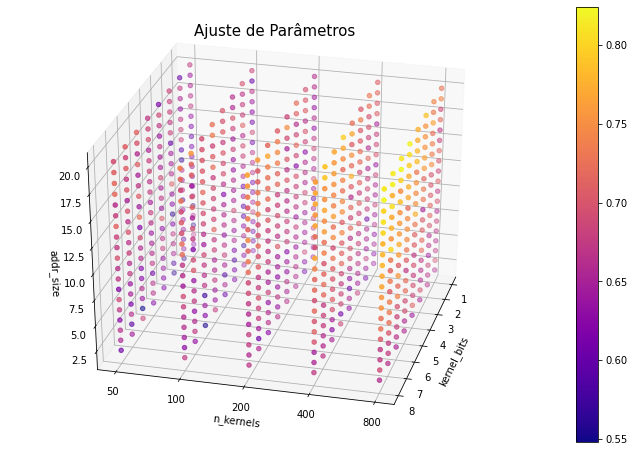

In [ ]:
fig = plt.figure()
fig.set_size_inches(12,8)
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(x, y, z, c=acc, cmap=plt.plasma())
fig.colorbar(img)
ax.set_xlabel('kernel_bits')
ax.set_ylabel('n_kernels')
ax.set_zlabel('addr_size')
ax.set_yticks(np.arange(len(n_kernels)))
ax.set_yticklabels(n_kernels)
plt.title('Ajuste de Parâmetros', size = 15)
ax.view_init(elev=30., azim=3.6*4)
plt.savefig(directoryName+"/resultados/Parameter_kc_tuning.png")
plt.show()

In [ ]:
data_for_anova = pd.DataFrame.from_dict({'param_kernel_size':x,'param_n_kernels':y,'param_addr_size':z,'acc':acc,'params':params_col,'time':tempo})
data_for_anova.to_csv(directoryName+'resultados/data_for_anova.csv')
path = directoryName+'resultados/data_for_anova.csv'
metric = 'acc'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_kernel_canvas_acc.txt',index=False)
metric = 'time'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_kernel_canvas_time.txt',index=False)


100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


In [ ]:
n_kernels

[50, 100, 200, 400, 800]

In [ ]:
def getTrainTestBinarized(D_treino,D_teste,min_,max_,size):
      X_treino,y_treino = list(binarizar_com_Termometro(dict(D_treino),Max=max_,Min=min_,termometherSize=size).values())
      X_teste,y_teste = list(binarizar_com_Termometro(dict(D_teste),Max=max_,Min=min_,termometherSize=size).values())
      return X_treino,y_treino,X_teste,y_teste

## Pipeline

In [ ]:
def pipeline(layer_no,term_size,addr_size,method,plot=False):
  D_treino,D_teste = splitData(True,layer_no,method)
  applyZScore(D_treino,D_teste)
  applyTANH(D_treino,D_teste)
  #replicateFeatures(D_treino,D_teste)
  max_ = np.max([D_treino['pia'][0].max(),D_treino['vio'][0].max()])
  min_ = np.min([D_treino['pia'][0].min(),D_treino['vio'][0].min()])
  X_treino,y_treino,X_teste,y_teste = getTrainTestBinarized(D_treino,D_teste,min_,max_,term_size)
  acc_media,acc_std,tempo_medio,tempo_std = validacao_cruzada(X_treino.tolist(),y_treino.tolist(),
                                                              metric_func=accuracy_score,
                                                              classificador='wisard',
                                                              addressSize=addr_size)
  clf = wp.Wisard(addr_size)
  clf.train(X_treino,y_treino)
  pred = clf.classify(X_teste)
  acc_teste = accuracy_score(y_teste,pred)
  if plot:
    plot_confusion_matrix(y_teste,pred,classes=['Piano', 'Violino'],title="ConfusionMatrix")
  return acc_teste,acc_media,acc_std,tempo_medio,tempo_std

In [ ]:
"""resultados = {}
resultados["acc_teste"] = 0
resultados["acc_media"] = 0
resultados["acc_std"] = 0
resultados["tempo_medio"] = 0
resultados["tempo_std"] = 0
methodsNames = []
methodsNames.extend(['Original','PCA','KPCA'])
for method in methodsNames:
  os.mkdir(directoryName+"resultados/{}/".format(method))
  for layer_no in range(0,13):
    vec = pipeline(layer_no,7,32,method)
    resultados["acc_teste"] = vec[0]
    resultados["acc_media"] = vec[1]
    resultados["acc_std"] = vec[2]
    resultados["tempo_medio"] = vec[3]
    resultados["tempo_std"] = vec[4]
    with open(directoryName+"resultados/{}/data_layer{}.pickle".format(method,layer_no),"wb") as f:
      pickle.dump(resultados,f)"""

'resultados = {}\nresultados["acc_teste"] = 0\nresultados["acc_media"] = 0\nresultados["acc_std"] = 0\nresultados["tempo_medio"] = 0\nresultados["tempo_std"] = 0\nmethodsNames = []\nmethodsNames.extend([\'Original\',\'PCA\',\'KPCA\'])\nfor method in methodsNames:\n  os.mkdir(directoryName+"resultados/{}/".format(method))\n  for layer_no in range(0,13):\n    vec = pipeline(layer_no,7,32,method)\n    resultados["acc_teste"] = vec[0]\n    resultados["acc_media"] = vec[1]\n    resultados["acc_std"] = vec[2]\n    resultados["tempo_medio"] = vec[3]\n    resultados["tempo_std"] = vec[4]\n    with open(directoryName+"resultados/{}/data_layer{}.pickle".format(method,layer_no),"wb") as f:\n      pickle.dump(resultados,f)'

In [ ]:
resultados = {}
methodsNames = []
methodsNames.extend(['Original','PCA','KPCA'])
for method in methodsNames:
  resultados[method] = {}
  res_layer_agg = {}
  res_layer_agg["acc_teste"] = []
  res_layer_agg["acc_media"] = []
  res_layer_agg["acc_std"] = []
  res_layer_agg["tempo_medio"] = []
  res_layer_agg["tempo_std"] = []
  for layer_no in range(0,13):
    with open(directoryName+"resultados/{}/data_layer{}.pickle".format(method,layer_no),"rb") as f:
      res_layer = pickle.load(f)
      for key in res_layer_agg.keys():
        res_layer_agg[key].append(res_layer[key])
  resultados[method] = res_layer_agg


In [ ]:
resultados['Original']['acc_teste']

[0.8534883720930233,
 0.8348837209302326,
 0.8651162790697674,
 0.8674418604651163,
 0.8627906976744186,
 0.8558139534883721,
 0.8209302325581396,
 0.8348837209302326,
 0.8395348837209302,
 0.8302325581395349,
 0.813953488372093,
 0.7883720930232558,
 0.8162790697674419]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


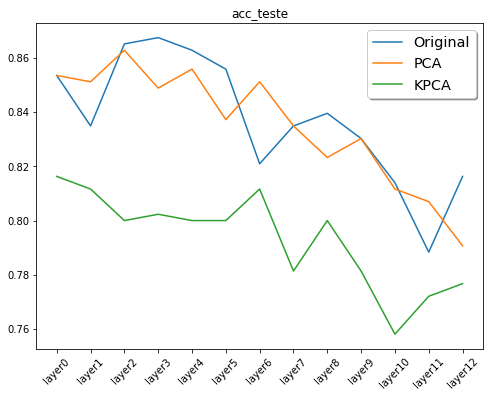

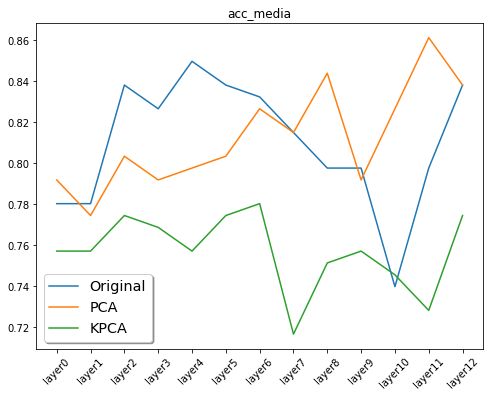

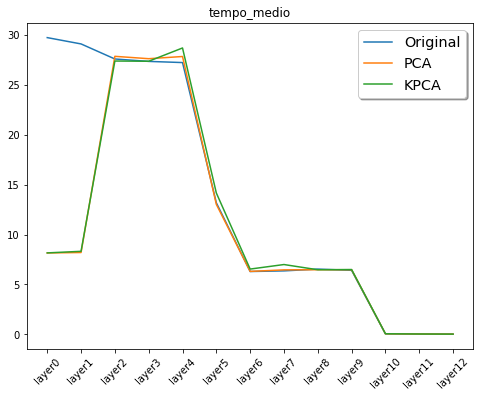

In [ ]:
layers = ["layer{}".format(i) for i in range(13)]
for metrics in resultados['Original'].keys():
  if metrics.endswith('std'):
    pass
  else:
    fig, ax = plt.subplots()
    fig.set_size_inches((8,6))
    for method in methodsNames:
      ax.plot(resultados[method][metrics],label=method)
    legend = ax.legend(loc='bottom left', shadow=True, fontsize='x-large')
    plt.title(metrics)
    ax.set_xticks(np.arange(len(layers)))
    ax.set_xticklabels(layers)
    plt.xticks(rotation=45)
    plt.savefig(directoryName+"resultados/"+metrics+".png")

In [ ]:
x = []
y = []
params_col = []
acc = []
tempo = []
for layer_no in range(0,13):
  for method in methodsNames:
    x.append(layer_no)
    y.append(method)
    par = str({'layer_no':layer_no,'method':method})
    params_col.append(str(par))
    acc.append(resultados[method]["acc_teste"][layer_no])
    tempo.append(resultados[method]["tempo_medio"][layer_no])

In [ ]:
data_for_anova = pd.DataFrame.from_dict({'param_layer_no':x,'param_method':y,'acc':acc,'params':params_col,'time':tempo})
data_for_anova.to_csv(directoryName+'resultados/data_for_anova3.csv')
path = directoryName+'resultados/data_for_anova3.csv'
metric = 'acc'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_layer_no_acc.txt',index=False)
metric = 'time'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_layer_no_time.txt',index=False)

100%|██████████| 3/3 [00:00<00:00, 34.45it/s]


In [ ]:
#resultados = {}
"""methodsNames = []
methodsNames.extend(['Original','PCA','KPCA'])
layer_no = 3
for term_size in range(9):
  resultados[term_size] = {}
  for method in methodsNames:
    resultados[term_size][method] = {}
    resultados[term_size][method]["acc_teste"] = []
    resultados[term_size][method]["acc_media"] = []
    resultados[term_size][method]["acc_std"] = []
    resultados[term_size][method]["tempo_medio"] = []
    resultados[term_size][method]["tempo_std"] = []
    for addr in addr_size:
      vec = pipeline(layer_no,term_size,addr,method)
      resultados[term_size][method]["acc_teste"].append(vec[0])
      resultados[term_size][method]["acc_media"].append(vec[1])
      resultados[term_size][method]["acc_std"].append(vec[2])
      resultados[term_size][method]["tempo_medio"].append(vec[3])
      resultados[term_size][method]["tempo_std"].append(vec[4])
    with open(directoryName+"/resultados/data3.pickle","wb") as f:
      pickle.dump(resultados,f)"""

'methodsNames = []\nmethodsNames.extend([\'Original\',\'PCA\',\'KPCA\'])\nlayer_no = 3\nfor term_size in range(9):\n  resultados[term_size] = {}\n  for method in methodsNames:\n    resultados[term_size][method] = {}\n    resultados[term_size][method]["acc_teste"] = []\n    resultados[term_size][method]["acc_media"] = []\n    resultados[term_size][method]["acc_std"] = []\n    resultados[term_size][method]["tempo_medio"] = []\n    resultados[term_size][method]["tempo_std"] = []\n    for addr in addr_size:\n      vec = pipeline(layer_no,term_size,addr,method)\n      resultados[term_size][method]["acc_teste"].append(vec[0])\n      resultados[term_size][method]["acc_media"].append(vec[1])\n      resultados[term_size][method]["acc_std"].append(vec[2])\n      resultados[term_size][method]["tempo_medio"].append(vec[3])\n      resultados[term_size][method]["tempo_std"].append(vec[4])\n    with open(directoryName+"/resultados/data3.pickle","wb") as f:\n      pickle.dump(resultados,f)'

In [ ]:
resultados = {}
with open(directoryName+"/resultados/data3.pickle","rb") as f:
  resultados = pickle.load(f)

In [ ]:
resultados[8]['PCA'].keys()

dict_keys(['acc_teste', 'acc_media', 'acc_std', 'tempo_medio', 'tempo_std'])

In [ ]:
kernel_bits = list(range(1,9))
addr_size = list(range(2,21))
x = []
y = []
z = []
params_col = []
acc = []
tempo = []
for b in kernel_bits:
  for n,method in enumerate(methodsNames):
    for num,addr in enumerate(addr_size):
      par = str({'thermometer_size':b,'method':method,'addr_size':addr})
      x.append(b)
      y.append(n)
      z.append(addr)
      params_col.append(par.replace('\"',''))
      acc.append(resultados[b][method]['acc_teste'][num])
      tempo.append(resultados[b][method]["tempo_medio"][num])

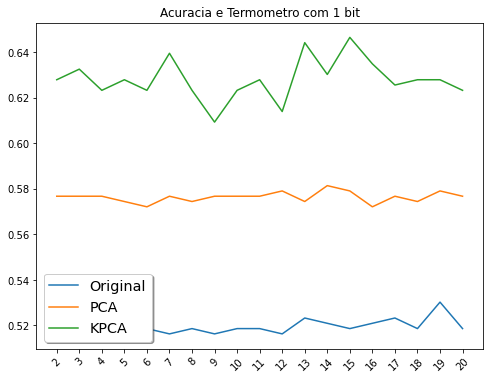

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((8,6))
for method in methodsNames:
  ax.plot(resultados[1][method]['acc_teste'],label=method)
  legend = ax.legend(loc='lower left', shadow=True, fontsize='x-large')
  plt.title('Acuracia e Termometro com 1 bit')
  ax.set_xticks(np.arange(len(addr_size)))
  ax.set_xticklabels(addr_size)
  plt.xticks(rotation=45)

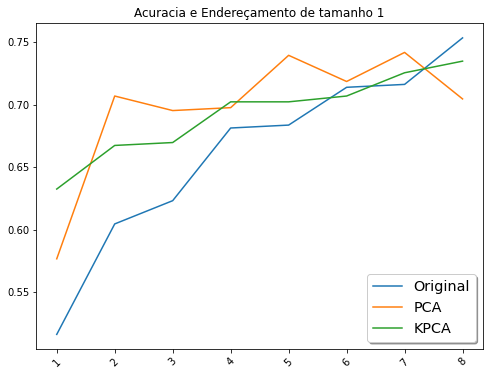

In [ ]:
otherPlot = {}
for method in methodsNames:
  otherPlot[method] = []
  for term_size in range(1,9):
    otherPlot[method].append(resultados[term_size][method]['acc_teste'][1])
fig, ax = plt.subplots()
fig.set_size_inches((8,6))
for method in methodsNames:
  ax.plot(otherPlot[method],label=method)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
  plt.title('Acuracia e Endereçamento de tamanho 1')
  ax.set_xticks(np.arange(len(otherPlot['KPCA'])))
  ax.set_xticklabels(np.arange(len(otherPlot['KPCA']))+1)
  plt.xticks(rotation=45)

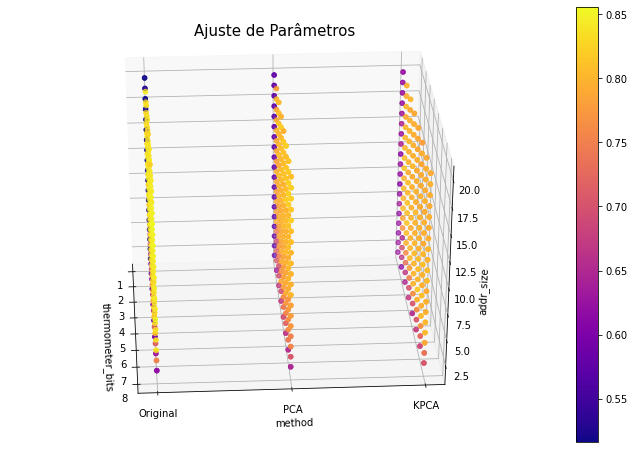

In [ ]:
fig = plt.figure()
fig.set_size_inches(12,8)
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(x, y, z, c=acc, cmap=plt.plasma())
fig.colorbar(img)
ax.set_xlabel('thermometer_bits')
ax.set_ylabel('method')
ax.set_zlabel('addr_size')
ax.set_yticks(np.arange(len(methodsNames)))
ax.set_yticklabels(methodsNames)
plt.title('Ajuste de Parâmetros', size = 15)
ax.view_init(elev=30., azim=3.6*7)
plt.savefig(directoryName+"/resultados/Parameter_termometro_tuning.png")

def init():
    ax.scatter(x, y, z, c=acc, cmap=plt.plasma())
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=1000, blit=True)    

HTML(ani.to_html5_video())


In [ ]:
data_for_anova = pd.DataFrame.from_dict({'param_thermometer_size':x,'param_method':y,'param_addr_size':z,'acc':acc,'params':params_col,'time':tempo})
data_for_anova.to_csv(directoryName+'resultados/data_for_anova2.csv')
path = directoryName+'resultados/data_for_anova2.csv'
metric = 'acc'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_fixed_layer_acc.txt',index=False)
metric = 'time'
df,params = hyanova.read_csv(path,metric)
importance = hyanova.analyze(df)
importance.to_latex(directoryName+'resultados/hyperparameter_importance_fixed_layer_time.txt',index=False)

100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Shape: (16544,)
Shape: (16544,)


(0.8395348837209302, 0.7976878612716763, 0.0, 34.1986870765686, 0.0)

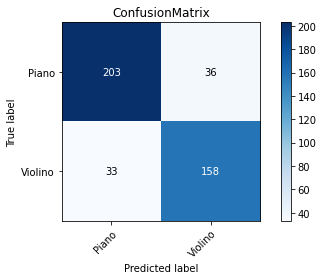

In [ ]:
pipeline(3,8,20,"Original",True)